In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

# def fun_v(t,x,v_t):
#   return v_t-0.01;

In [ ]:
# Set number of data points
N_0 = 150
N_b = 100
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

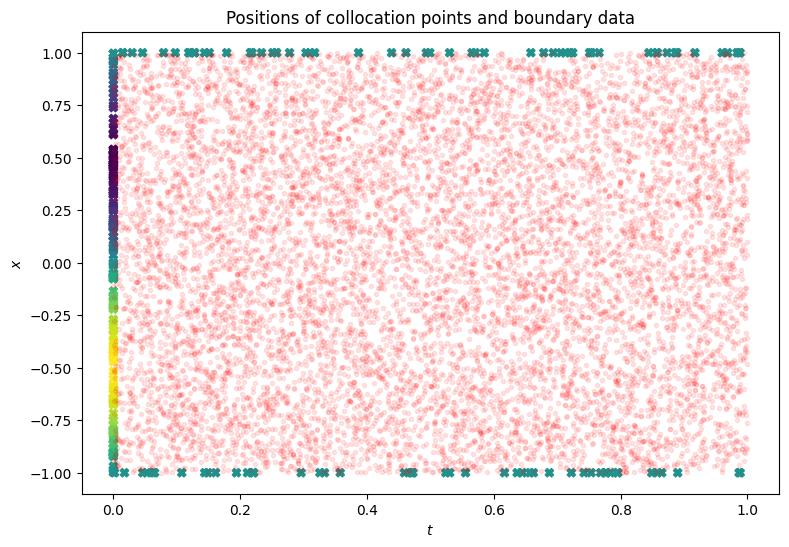

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [ ]:
def init_model(num_hidden_layers=2, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

In [ ]:
def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)

        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx)

In [ ]:
def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

In [ ]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
print(model.get_weights())

[array([[ 0.419865  ,  0.03150144, -0.16680089,  0.07631958,  0.07587612,
         0.01953467, -0.068278  , -0.20515893,  0.2307684 , -0.1512091 ,
         0.32915854,  0.34460685,  0.2056446 , -0.12926899,  0.12070225,
        -0.05234371,  0.20649542,  0.43800268,  0.3597258 , -0.30169064],
       [ 0.01866367, -0.06486604,  0.06979988,  0.3426588 , -0.1941097 ,
         0.43317467,  0.24077071,  0.0805607 , -0.46667376,  0.24492288,
        -0.5003325 ,  0.05024765, -0.05261938,  0.35216504, -0.42784742,
         0.20688617,  0.05638556,  0.24013513, -0.13470228, -0.22454375]],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), array([[ 1.43690705e-01,  1.65619999e-01, -2.29716226e-02,
         2.72453904e-01, -2.25270256e-01, -4.14297312e-01,
         1.91262156e-01, -9.40481946e-02, -2.30157331e-01,
        -3.73137385e-01, -1.41041115e-01,  8.28690529e-02,
         2.08676398e-01, -6.23219870e-02, -

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%500 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.61043167e+00
It 00500: loss = 1.16474286e-01
It 01000: loss = 8.95115882e-02
It 01500: loss = 8.84030312e-02
It 02000: loss = 8.69566798e-02
It 02500: loss = 8.51620808e-02
It 03000: loss = 8.31521899e-02
It 03500: loss = 8.20847675e-02
It 04000: loss = 8.09241459e-02
It 04500: loss = 7.96474367e-02
It 05000: loss = 7.82484338e-02

Computation time: 106.10849690437317 seconds


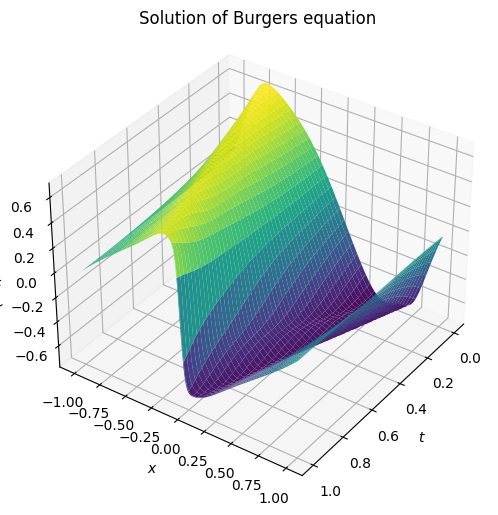

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

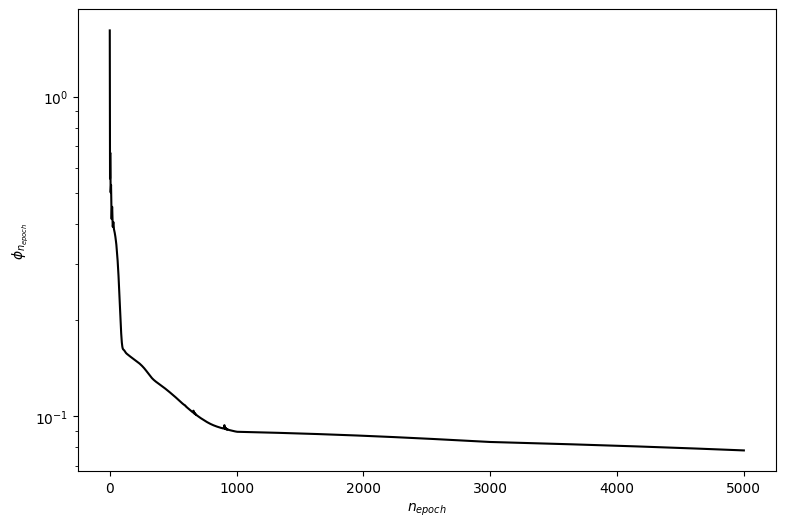

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

In [ ]:
# model.save("./checkpoints_save/weights")

In [ ]:
#  !zip -r weights.zip ./checkpoints_save/

In [ ]:
print(model.get_weights())

[array([[ 0.5760166 , -1.5843308 , -0.20047662,  0.14731959,  0.12456432,
        -0.289102  , -0.06955845, -0.11252802,  0.2716547 ,  0.2444669 ,
         0.5186295 ,  0.28947806,  0.52812046, -1.7180979 ,  0.1928854 ,
         0.4164122 ,  0.01136884,  0.37318945,  0.26945564, -0.24008287],
       [-0.09198605, -3.76278   ,  0.13645999,  0.38237306, -0.32112125,
         0.8688248 ,  0.34140432,  0.77751034, -0.8939412 ,  1.4966418 ,
        -1.2111136 , -0.12910771, -0.7456161 ,  4.1279383 , -0.6608983 ,
         0.82875896,  0.35096344,  0.6831791 , -0.3856792 , -0.16453482]],
      dtype=float32), array([ 0.30788192,  1.4327861 , -0.25676662,  0.3560837 ,  0.17412701,
        0.44476065,  0.07644869,  0.4671101 , -0.20726117, -0.13201565,
       -0.60466594,  0.17123176,  1.5699672 ,  2.0850248 , -0.16146106,
       -0.56470335,  0.0835697 , -0.21742249, -0.03163977, -0.11032906],
      dtype=float32), array([[ 1.14394613e-01, -2.81079441e-01, -3.73649821e-02,
         2.70738900e

In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)
def fun_v_0(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)
# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)
def fun_v_b(t, x):
    n = x.shape[0]
    return 0.01*t;


In [ ]:
# Set number of data points
N_0 = 150
N_b = 100
N_r = 20000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)
v_0 = fun_v_0(x_0)
# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)
v_b = fun_v_b(t_b,x_b)
# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]
v_data = [v_0, v_b]

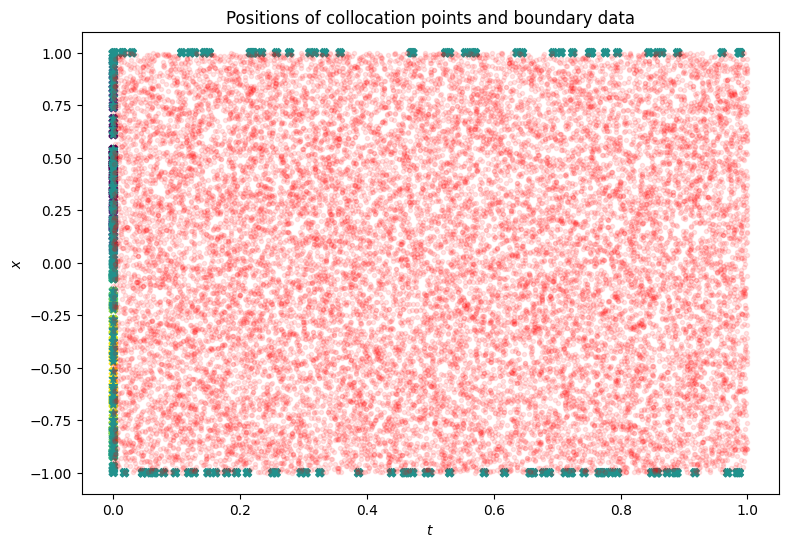

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_0, x_0, c=v_0, marker='*', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=v_b, marker='*', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [ ]:
def init_Model(num_hidden_layers=2, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model_new = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model_new.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model_new.add(scaling_layer)

    # Add the first hidden layer
    model_new.add(tf.keras.layers.Dense(num_neurons_per_layer,
        activation=tf.keras.activations.get('tanh'),
        kernel_initializer='glorot_normal'))

    # Add the second hidden layer
    model_new.add(tf.keras.layers.Dense(num_neurons_per_layer,
        activation=tf.keras.activations.get('tanh'),
        kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model_new.add(tf.keras.layers.Dense(2))
    for i in range(len(model.layers)):
        if len(model.layers[i].get_weights()) > 0:
                if i != len(model.layers) - 1:
                  weights, biases = model.layers[i].get_weights()
                  model_new.layers[i].set_weights([weights, biases])

    return model_new


In [ ]:
# model = init_model()

# # Initialize a new model with the same architecture as init_model
model_new = init_Model()

# # Iterate through the layers of the models and print the weights
for i in range(len(model.layers)):
  if len(model.layers[i].get_weights()) > 0:
    if i != len(model.layers) - 1:

        # Check and print the weights of the hidden layers
      weights, biases = model.layers[i].get_weights()
      print(f"Weights for layer {i} in model:")
      print(model.layers[i].get_weights()[0])
      print(f"biases for layer {i} in model:")
      print(model.layers[i].get_weights()[1])
      print(f"Weights for layer {i} in model_new:")
      print(model_new.layers[i].get_weights()[0])
      print(f"biases for layer {i} in model_new:")
      print(model_new.layers[i].get_weights()[1])


Weights for layer 1 in model:
[[ 0.5760166  -1.5843308  -0.20047662  0.14731959  0.12456432 -0.289102
  -0.06955845 -0.11252802  0.2716547   0.2444669   0.5186295   0.28947806
   0.52812046 -1.7180979   0.1928854   0.4164122   0.01136884  0.37318945
   0.26945564 -0.24008287]
 [-0.09198605 -3.76278     0.13645999  0.38237306 -0.32112125  0.8688248
   0.34140432  0.77751034 -0.8939412   1.4966418  -1.2111136  -0.12910771
  -0.7456161   4.1279383  -0.6608983   0.82875896  0.35096344  0.6831791
  -0.3856792  -0.16453482]]
biases for layer 1 in model:
[ 0.30788192  1.4327861  -0.25676662  0.3560837   0.17412701  0.44476065
  0.07644869  0.4671101  -0.20726117 -0.13201565 -0.60466594  0.17123176
  1.5699672   2.0850248  -0.16146106 -0.56470335  0.0835697  -0.21742249
 -0.03163977 -0.11032906]
Weights for layer 1 in model_new:
[[ 0.5760166  -1.5843308  -0.20047662  0.14731959  0.12456432 -0.289102
  -0.06955845 -0.11252802  0.2716547   0.2444669   0.5186295   0.28947806
   0.52812046 -1.7180

In [ ]:
# model_new.summary()

In [ ]:
def fun_r(t, x, u, v, u_t, u_x, u_xx, v_t):
    pde1 = u_t + u * u_x - v * u_xx
    pde2 = v_t - 0.01
    return pde1, pde2

In [ ]:
def Get_r(model_new, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x and v_t
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        # u = model_new(tf.stack([t[:,0], x[:,0]], axis=1))
        # v = model_new(tf.stack([t[:,0], x[:,0]], axis=1))

        uv = model_new(tf.stack([t[:, 0], x[:, 0]], axis=1))
        u, v = tf.split(uv, 2, axis=1)
        # Compute gradient u_x within the GradientTape
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
        v_t = tape.gradient(v, t)
        pde1 = u_t + u * u_x - v * u_xx
        pde2 = v_t-0.01
    del tape
    return [pde1, pde2]

In [ ]:
def Compute_loss(model_new, X_r, X_data, u_data, v_data):
    # Compute residuals
    r1, r2 = Get_r(model_new, X_r)
    phi_r = tf.reduce_mean(tf.square(r1))
    phi_v = tf.reduce_mean(tf.square(r2))

    # Initialize loss
    loss = phi_r + phi_v

    # Compute prediction for X_data
    # u_pred, v_pred = tf.split(model_new(tf.concat(X_data, axis=0)), 2, axis=1)

    for i in range(len(X_data)):
      # u_pred = model(X_data[i])
        u_pred, v_pred = tf.split(model_new(tf.concat(X_data[i], axis=0)), 2, axis=1)
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred)) + tf.reduce_mean(tf.square(v_data[i] - v_pred))

    return loss

In [ ]:
def Get_grad(model_new, X_r, X_data, u_data,v_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model_new.trainable_variables)
        loss = Compute_loss(model_new, X_r, X_data, u_data,v_data)

    g = tape.gradient(loss, model_new.trainable_variables)
    del tape

    return loss, g

In [ ]:
# Initialize model aka u_\theta
model_new = init_Model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 3000], [1e-2, 1e-3, 5e-4])  # Adjusted learning rate

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = Get_grad(model_new, X_r, X_data, u_data,v_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model_new.trainable_variables))

    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%500 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 7.64514343e+02
It 00500: loss = 2.52875298e-01
It 01000: loss = 1.15376309e-01
It 01500: loss = 1.04750499e-01
It 02000: loss = 9.22724158e-02
It 02500: loss = 7.86833391e-02
It 03000: loss = 6.52519837e-02
It 03500: loss = 5.86557426e-02
It 04000: loss = 5.19968718e-02
It 04500: loss = 4.55986597e-02
It 05000: loss = 3.96473221e-02

Computation time: 230.93245029449463 seconds


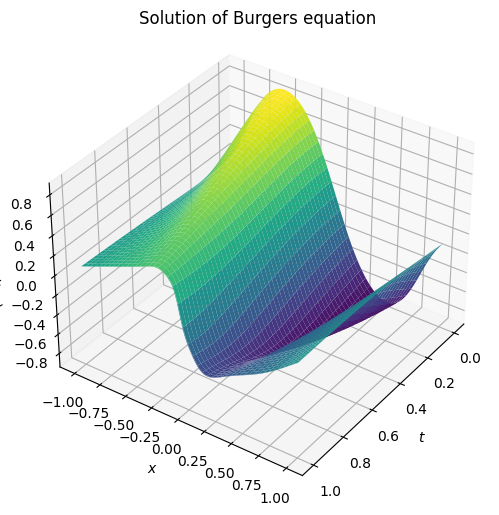

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(), X.flatten()]).T

# Determine predictions of u(t, x)
upred = model_new(tf.cast(Xgrid, DTYPE))

# Reshape upred
U = upred[:, 0].numpy().reshape(N+1, N+1)  # Assuming u is the first output

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(35, 35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation')

plt.show()



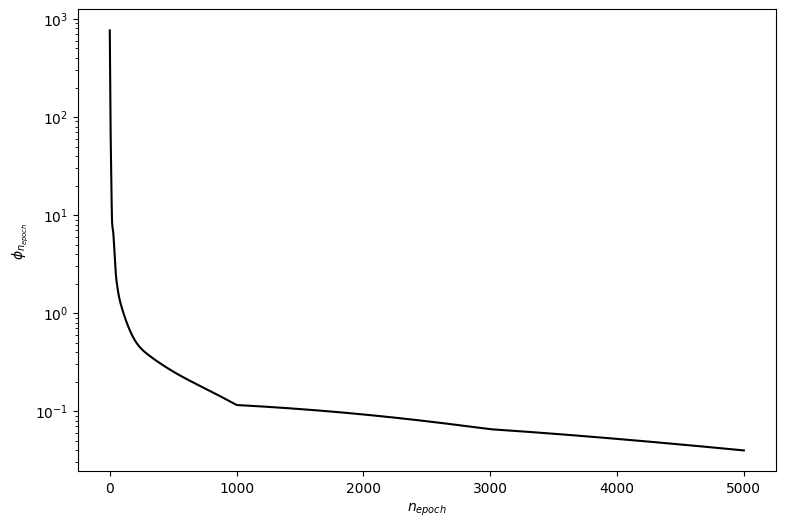

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

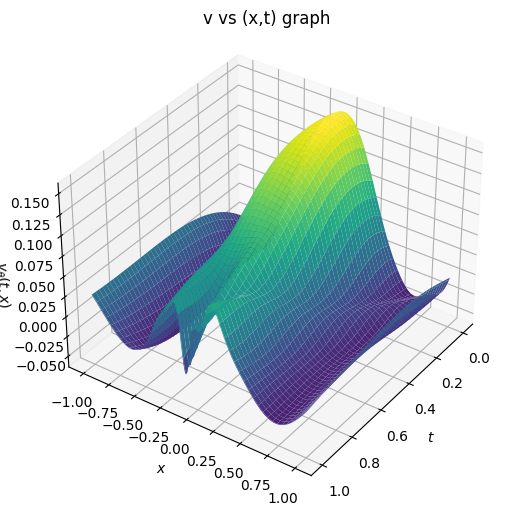

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(), X.flatten()]).T

# Determine predictions of u(t, x)
upred = model_new(tf.cast(Xgrid, DTYPE))

# Reshape upred
U = upred[:, 1].numpy().reshape(N+1, N+1)  # Assuming u is the first output

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(35, 35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$v_\\theta(t,x)$')
ax.set_title('v vs (x,t) graph')

plt.show()

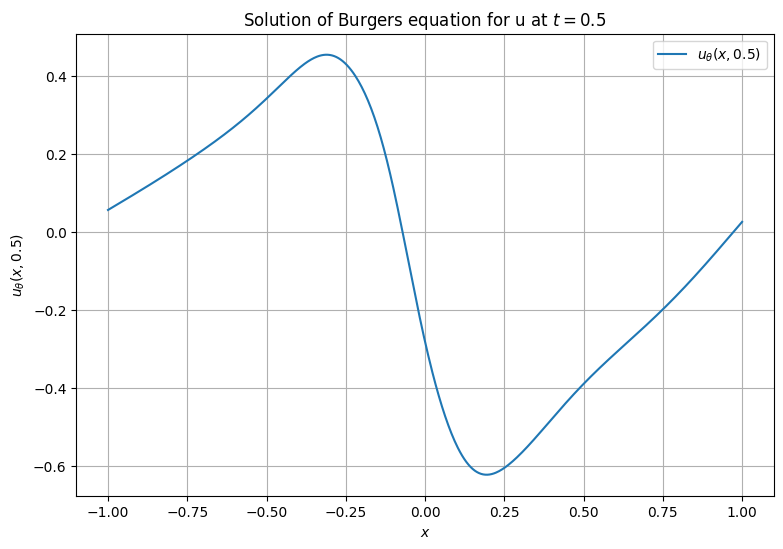

In [ ]:
# Fix t at 0.5
fixed_t = 0.8 * np.ones_like(xspace)

# Stack the fixed_t and x values
X_fixed_t = np.vstack([fixed_t, xspace]).T

# Determine predictions of u(x, 0.5) - assuming it's the first output
upred_at_fixed_t = model_new(tf.cast(X_fixed_t, DTYPE))[:, 0].numpy()

# Plot u(x, 0.5)
plt.figure(figsize=(9, 6))
plt.plot(xspace, upred_at_fixed_t, label='$u_\\theta(x, 0.5)$')
plt.xlabel('$x$')
plt.ylabel('$u_\\theta(x, 0.5)$')
plt.title('Solution of Burgers equation for u at $t = 0.5$')
plt.legend()
plt.grid(True)
plt.show()


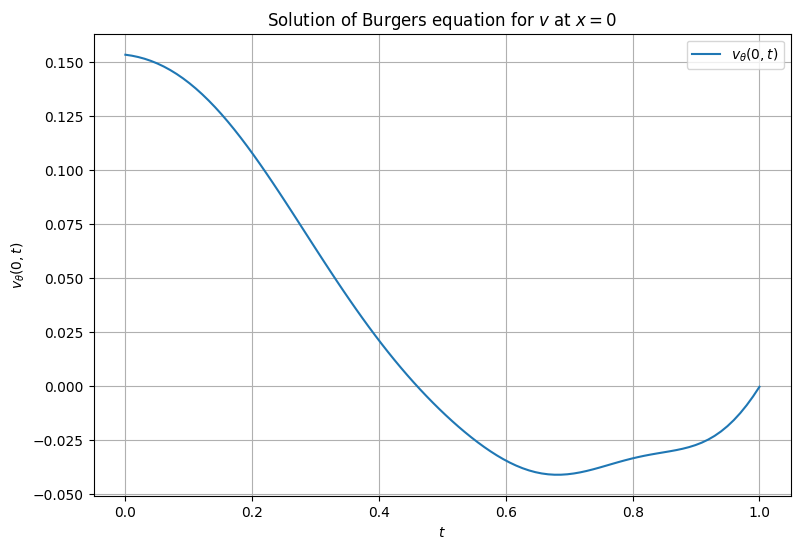

In [ ]:
# Set a constant x value for which you want to plot t vs v
constant_x = 0  # Adjust this value as needed

# Generate an array of t values
t_values = np.linspace(tmin, tmax, 100)  # Adjust the number of points as needed

# Stack the constant x and t values
X_constant_x = np.vstack([constant_x * np.ones_like(t_values), t_values]).T

# Determine predictions of v for the constant x and varying t
vpred_at_constant_x = model_new(tf.cast(X_constant_x, DTYPE))[:, 1].numpy()

# Plot t vs v for the constant x
plt.figure(figsize=(9, 6))
plt.plot(t_values, vpred_at_constant_x, label=f'$v_\\theta({constant_x}, t)$')
plt.xlabel('$t$')
plt.ylabel(f'$v_\\theta({constant_x}, t)$')
plt.title(f'Solution of Burgers equation for $v$ at $x = {constant_x}$')
plt.legend()
plt.grid(True)
plt.show()


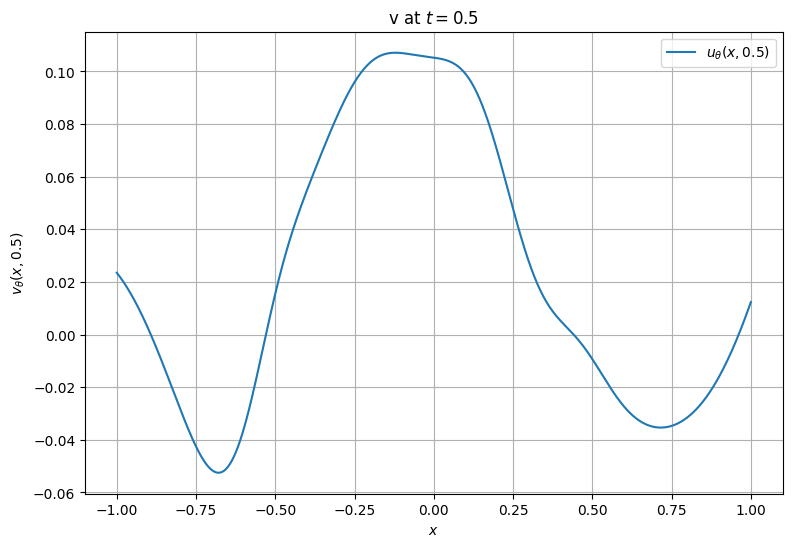

In [ ]:
# Fix t at 0.5
fixed_t = 0.5 * np.ones_like(xspace)

# Stack the fixed_t and x values
X_fixed_t = np.vstack([fixed_t, xspace]).T

# Determine predictions of u(x, 0.5) - assuming it's the first output
upred_at_fixed_t = model_new(tf.cast(X_fixed_t, DTYPE))[:, 1].numpy()

# Plot u(x, 0.5)
plt.figure(figsize=(9, 6))
plt.plot(xspace, upred_at_fixed_t, label='$u_\\theta(x, 0.5)$')
plt.xlabel('$x$')
plt.ylabel('$v_\\theta(x, 0.5)$')
plt.title('v at $t = 0.5$')
plt.legend()
plt.grid(True)
plt.show()
